In [3]:
import prior_envs
from ipypb import track as tqdm
import torch
import astar
import diffplan
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numba
import random
%load_ext autoreload
%autoreload 2
%matplotlib inline

eps = torch.finfo().eps

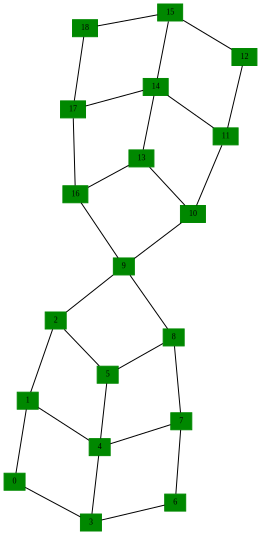

In [7]:
env = prior_envs.f2d
diffplan.plot_graph(env, labels=[str(x) for x in env.states])

In [144]:
s = 1
g = 17

option_set = [9]

%time D = diffplan.compute_distance_matrix(env)
BFS = diffplan.compute_bfs_matrix(env, D)

states = env.states

actions = np.array([
    [
        env.step(s, a)[0]
        for a in env.actions
    ]
    for s in env.states
], dtype=np.int)

def make_options(g):
    options = np.array([
        [o for o in option_set+[g]]
        for s in env.states
    ], dtype=np.int)
    return option_set+[g], options

def find_probe(s, g, probe, step_cost, debug=False):
    option_list, options = make_options(g)

    op = 0
    plan, plan_options = search(s, options, g, step_cost=step_cost)[:2]
    if debug: print(plan, plan_options)
    for s in plan:
        op += 1
        if s == probe:
            return op, True
    # If probe was an option, we should now reject since it isn't in our plan.
    if probe in options:
        return op, False

    if debug: print('Planning for each option')
    for s, o in zip(plan, plan_options):
        if debug: print(s, o, option_list[o], plan)
        plan, _ = search(s, actions, option_list[o])[:2]
        for s in plan:
            op += 1
            if s == probe:
                return op, True
    return op, False


def search(start, T, goal, *, iters=len(states), step_cost=1):
    if np.size(step_cost) == 1:
        step_cost = np.full((len(states), len(states)), step_cost)
    assert np.any(T==goal), 'Bare minimum to make sure things are sorta configured'
    V = np.zeros(len(states))
    for _ in range(iters):
        prev = np.copy(V)
        for s in states:
            if s == goal:
                continue
            ns = T[s]
            Q = V[ns] - step_cost[s, ns]
            V[s] = np.max(Q)
        if np.linalg.norm(prev - V) < 1e-3:
            break
    # Now make path
    path = [start]
    actions = []
    while path[-1] != goal:
        s = path[-1]
        ns = T[s]
        Q = V[ns] - step_cost[s, ns]
        a = np.argmax(Q)
        actions.append(a)
        path.append(ns[a])
        if len(path) > len(states):
            break
    return path, actions, V

assert search(0, actions, 1)[0] == [0, 1]
assert search(0, actions, 2)[0] == [0, 1, 2]
assert search(0, actions, 6)[0] == [0, 3, 6]
assert search(0, actions, 10)[0] == [0, 1, 2, 9, 10]

CPU times: user 105 ms, sys: 1.86 ms, total: 107 ms
Wall time: 109 ms


In [150]:
step_cost = D + BFS
path, _, V = search(1, make_options(11)[1], 11, step_cost=step_cost.numpy())
assert path == [1, 9, 11]

In [151]:
assert find_probe(1, 17, 9, step_cost=step_cost.numpy()) == (2, True)
assert find_probe(1, 10, 2, step_cost=step_cost.numpy(), debug=True) == (5, True)

[1, 9, 10] [0, 1]
Planning for each option
1 0 9 [1, 9, 10]


In [202]:
nb = [2, 8, 10, 16]
experiments = [
    ((0, 1, 2), (10, 11, 12), 9, [2, 10], True),
    ((6, 7, 8), (10, 11, 12), 9, [8, 10], True),

    ((0, 1, 2), (16, 17, 18), 9, [2, 16], True),
    ((6, 7, 8), (16, 17, 18), 9, [8, 16], True),

    ((0, 1, 2), (6, 7, 8), 9, nb, False),
    ((10, 11, 12), (16, 17, 18), 9, nb, False),
]

In [203]:
import itertools
import pandas as pd

sc = (D+BFS).numpy()

data = []

for source, dest, bottle, nonbottles, nonloc in tqdm(experiments):
    for s, d in itertools.product(source, dest):
        cost, affirm = find_probe(s, d, bottle, step_cost=sc)
        data.append(dict(cost=cost, affirm=affirm, nonloc=nonloc, bottle=True))
        for nonbottle in nonbottles:
            cost, affirm = find_probe(s, d, nonbottle, step_cost=sc)
            data.append(dict(cost=cost, affirm=affirm, nonloc=nonloc, bottle=False))
    

 [████████████████████████████████████████████████████████████] 6/6 [00:01<00:00, 0.16s/it]

In [165]:
df = pd.DataFrame(data)
# affirm == nonloc
summary = df.groupby(['nonloc', 'bottle']).cost.mean().reset_index()
summary

,nonloc,bottle,cost
0,False,False,5.611111
1,False,True,2.000000
2,True,False,4.555556
3,True,True,2.000000


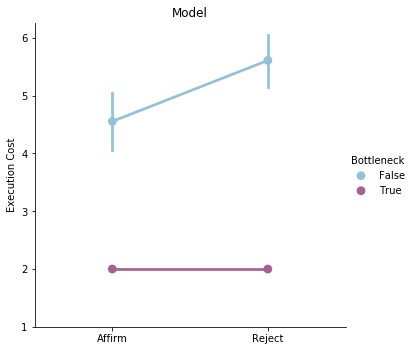

In [222]:
import seaborn as sns

df['Affirm'] = df['nonloc']
df['Execution Cost'] = df['cost']
df['Bottleneck'] = df['bottle']

#sns.lineplot(data=summary, x='affirm', order=[True, False], y='cost', hue='bottle', markers=True)
ax = sns.catplot(
    x='Affirm', y='Execution Cost', hue='Bottleneck', kind="point", data=df,
    order=[True, False],
    palette=[
        tuple(x/255 for x in (148, 192, 216, 255)),
        tuple(x/255 for x in (165, 97, 143, 255)),
    ]
)
#plt.xticks([0, 1])
#plt.xlim(1.1, -0.1)
ax.set(
    xticklabels=['Affirm', 'Reject'],
    xlabel='',
    title='Model',
)
plt.ylim(1, None)
plt.savefig('figures/model_of_solway2e.pdf')